# Neural Networks for MNIST dataset

In [2]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data import Dataset
import numpy as np
import pandas as pd

In [3]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Loading MNIST
Here we load the dataset and create data loaders.

In [4]:
train_ds = datasets.MNIST('../data', train=True, download=True, 
                       transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
test_ds = datasets.MNIST('../data', train=False, download=True, 
                       transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

In [5]:
batch_size = 64
#batch_size = 5 # for testing
kwargs = {'num_workers': 1, 'pin_memory': True} 

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False, **kwargs)

## Feed Forward Neural Network

In [6]:
# for the number of neurons in the hidden unit
def get_model(M = 300):
    net = nn.Sequential(nn.Linear(28*28, M),
                        nn.ReLU(),
                        nn.Linear(M, 10))
    return net.cuda()

In [7]:
def train_model(train_loader, test_loader, num_epochs, model, optimizer):
    
    for epoch in range(num_epochs):
        model.train()
        sum_loss = 0.0
        total = 0
        for i, (images, labels) in enumerate(train_loader):  
            batch = images.shape[0] # size of the batch
            # Convert torch tensor to Variable, change shape of the input
            images = Variable(images.view(-1, 28*28)).cuda()
            labels = Variable(labels).cuda()
        
            # Forward + Backward + Optimize
            optimizer.zero_grad()  # zero the gradient buffer
            outputs = model(images)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()
        
            total += batch
            sum_loss += batch * loss.data[0]
#             if (i+1) % 100 == 0:
#                 print ('Epoch [%d/%d], Loss: %.4f' 
#                    %(epoch+1, num_epochs, sum_loss/total))
                
        train_loss = sum_loss/total
        print('Epoch [%d/%d], Loss: %.4f' %(epoch+1, num_epochs, train_loss))
        val_acc, val_loss = model_accuracy_loss(model, test_loader)
        print('Epoch [%d/%d], Valid Accuracy: %.4f, Valid Loss: %.4f' %(epoch+1, num_epochs, val_acc, val_loss))
    return val_acc, val_loss, train_loss

In [8]:
def model_accuracy_loss(model, test_loader):
    model.eval()
    correct = 0
    sum_loss = 0.0
    total = 0
    for images, labels in test_loader:
        images = Variable(images.view(-1, 28*28)).cuda()
        labels = Variable(labels).cuda()
        outputs = model(images)
        _, pred = torch.max(outputs.data, 1)
        loss = F.cross_entropy(outputs, labels)
        sum_loss += labels.size(0)*loss.data[0]
        total += labels.size(0)
        correct += pred.eq(labels.data).cpu().sum()
    return 100 * correct / total, sum_loss/ total

## Question No 1

In [10]:
valid_acc = []
lr = [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]
for l in lr:
    net = get_model()
    optimizer = optim.Adam(net.parameters(), lr=l)
    train_model(train_loader, test_loader, num_epochs=10, model=net, optimizer=optimizer)
    vld_acc,_=model_accuracy_loss(net, test_loader)
    valid_acc.append(vld_acc)

Epoch [1/10], Loss: 84.2484
Epoch [1/10], Valid Accuracy: 13.7300, Valid Loss: 2.6949
Epoch [2/10], Loss: 3.0887
Epoch [2/10], Valid Accuracy: 11.7700, Valid Loss: 2.6268
Epoch [3/10], Loss: 2.3953
Epoch [3/10], Valid Accuracy: 11.1700, Valid Loss: 2.5699
Epoch [4/10], Loss: 2.4004
Epoch [4/10], Valid Accuracy: 10.4900, Valid Loss: 2.5607
Epoch [5/10], Loss: 2.3695
Epoch [5/10], Valid Accuracy: 10.0200, Valid Loss: 2.5570
Epoch [6/10], Loss: 2.3643
Epoch [6/10], Valid Accuracy: 10.0200, Valid Loss: 2.6581
Epoch [7/10], Loss: 2.3640
Epoch [7/10], Valid Accuracy: 11.5700, Valid Loss: 2.6079
Epoch [8/10], Loss: 2.3649
Epoch [8/10], Valid Accuracy: 9.7800, Valid Loss: 2.5598
Epoch [9/10], Loss: 2.3664
Epoch [9/10], Valid Accuracy: 9.7800, Valid Loss: 2.6625
Epoch [10/10], Loss: 2.3634
Epoch [10/10], Valid Accuracy: 10.3700, Valid Loss: 2.5903
Epoch [1/10], Loss: 2.9661
Epoch [1/10], Valid Accuracy: 38.4800, Valid Loss: 2.0190
Epoch [2/10], Loss: 2.0799
Epoch [2/10], Valid Accuracy: 16.5200

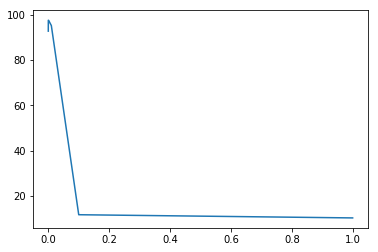

In [11]:
plt.plot(lr,valid_acc)

In [12]:
pd.DataFrame({'lr':lr,
             'vld_acc': valid_acc}).sort_values(by='vld_acc')

,lr,vld_acc
0,1.00000,10.37
1,0.10000,11.78
5,0.00001,92.79
2,0.01000,95.27
3,0.00100,97.57
4,0.00010,97.61


Here, we have the highest validation accuracy of 97.61%, when the learning rate is 0.001. Any learning rate lower than that takes a lot more time to train and there is no visible increase in accuracy per epoch

The best value of learning rate is 0.0001 and the next best value is 0.001. Therefore we know that the best value of learning ratelines in between these two values. Therefore,I estimated the best learning rate by interpolation.

In [20]:
print('Best Learning rate after interpolation: ',(0.0001+0.001)/2)

Best Learning rate after interpolation:  0.00055


## Question No 2

In [13]:
M = [10, 50, 100, 300, 1000, 2000]
lr=0.01
train_loss = []
valid_loss = []
valid_acc  = []
for m in M:
    net = get_model(M=m)
    optimizer = optim.Adam(net.parameters(), lr=lr)
    _,_ ,trn_loss=train_model(train_loader, test_loader, num_epochs=10, model=net, optimizer=optimizer)
    vld_acc,val_loss=model_accuracy_loss(net, test_loader)
    valid_loss.append(val_loss)
    train_loss.append(trn_loss)
    valid_acc.append(vld_acc)

Epoch [1/10], Loss: 0.5037
Epoch [1/10], Valid Accuracy: 88.8800, Valid Loss: 0.3981
Epoch [2/10], Loss: 0.4112
Epoch [2/10], Valid Accuracy: 89.7000, Valid Loss: 0.3681
Epoch [3/10], Loss: 0.3834
Epoch [3/10], Valid Accuracy: 89.7000, Valid Loss: 0.3725
Epoch [4/10], Loss: 0.3799
Epoch [4/10], Valid Accuracy: 90.0500, Valid Loss: 0.3729
Epoch [5/10], Loss: 0.3756
Epoch [5/10], Valid Accuracy: 89.3300, Valid Loss: 0.3806
Epoch [6/10], Loss: 0.3669
Epoch [6/10], Valid Accuracy: 90.1900, Valid Loss: 0.3602
Epoch [7/10], Loss: 0.3658
Epoch [7/10], Valid Accuracy: 89.5700, Valid Loss: 0.3676
Epoch [8/10], Loss: 0.3631
Epoch [8/10], Valid Accuracy: 89.7000, Valid Loss: 0.3740
Epoch [9/10], Loss: 0.3588
Epoch [9/10], Valid Accuracy: 90.2600, Valid Loss: 0.3615
Epoch [10/10], Loss: 0.3573
Epoch [10/10], Valid Accuracy: 89.1200, Valid Loss: 0.3930
Epoch [1/10], Loss: 0.2734
Epoch [1/10], Valid Accuracy: 94.2400, Valid Loss: 0.1928
Epoch [2/10], Loss: 0.1970
Epoch [2/10], Valid Accuracy: 94.750

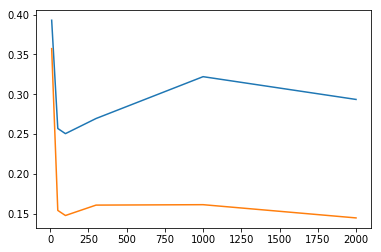

In [14]:
# Graph for train loss
plt.plot(M,valid_loss)
plt.plot(M,train_loss)

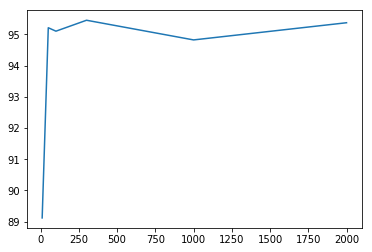

In [15]:
# Graph for validation loss
plt.plot(M,valid_acc)

In [16]:
pd.DataFrame({'M':M,
             'vld_acc': valid_acc}).sort_values(by='vld_acc')

,M,vld_acc
0,10,89.12
4,1000,94.82
2,100,95.10
1,50,95.21
5,2000,95.37
3,300,95.45


Here, we have the highest validation accuracy of 95.45%, when number of activations are 300. In the graph of validation loss, we can see that train loss decreases and increases slightly. This might be because for large number of neurons we would need more iterations to settle

To understand overfitting, look in the graph which plots train loss and validation loss Vs number of activations, I found that when number of activations in the hidden layer is more than 250, for a small decrease in training loss, the validation loss was increasing, This shows that there might be overfitting.

## Question No 3: Models with L2 regularization
To add L2 regularization use the `weight_decay` argument on the optimizer

In [22]:
M = 300
lr= 0.001
wd = [0, 0.0001, 0.001, 0.01, 0.1, 0.3]
train_loss = []
valid_loss = []
valid_acc  = []
for w in wd:
    net = get_model(M)
    optimizer = optim.Adam(net.parameters(), lr=lr,weight_decay=w)
    val_acc, val_loss, trn_loss=train_model(train_loader, test_loader, num_epochs=20, model=net, optimizer=optimizer)
    valid_acc.append(val_acc)
    valid_loss.append(val_loss)
    train_loss.append(trn_loss)

Epoch [1/20], Loss: 0.2226
Epoch [1/20], Valid Accuracy: 96.5300, Valid Loss: 0.1097
Epoch [2/20], Loss: 0.0900
Epoch [2/20], Valid Accuracy: 97.2600, Valid Loss: 0.0844
Epoch [3/20], Loss: 0.0629
Epoch [3/20], Valid Accuracy: 97.3400, Valid Loss: 0.0827
Epoch [4/20], Loss: 0.0445
Epoch [4/20], Valid Accuracy: 97.3900, Valid Loss: 0.0915
Epoch [5/20], Loss: 0.0376
Epoch [5/20], Valid Accuracy: 97.8200, Valid Loss: 0.0784
Epoch [6/20], Loss: 0.0277
Epoch [6/20], Valid Accuracy: 97.3400, Valid Loss: 0.0944
Epoch [7/20], Loss: 0.0233
Epoch [7/20], Valid Accuracy: 97.6800, Valid Loss: 0.0883
Epoch [8/20], Loss: 0.0216
Epoch [8/20], Valid Accuracy: 97.8500, Valid Loss: 0.0830
Epoch [9/20], Loss: 0.0168
Epoch [9/20], Valid Accuracy: 97.8300, Valid Loss: 0.0840
Epoch [10/20], Loss: 0.0149
Epoch [10/20], Valid Accuracy: 97.7000, Valid Loss: 0.0980
Epoch [11/20], Loss: 0.0140
Epoch [11/20], Valid Accuracy: 98.0500, Valid Loss: 0.0978
Epoch [12/20], Loss: 0.0134
Epoch [12/20], Valid Accuracy: 97

Epoch [16/20], Valid Accuracy: 89.8700, Valid Loss: 0.4415
Epoch [17/20], Loss: 0.4624
Epoch [17/20], Valid Accuracy: 89.6700, Valid Loss: 0.4493
Epoch [18/20], Loss: 0.4611
Epoch [18/20], Valid Accuracy: 90.0100, Valid Loss: 0.4368
Epoch [19/20], Loss: 0.4611
Epoch [19/20], Valid Accuracy: 90.2300, Valid Loss: 0.4382
Epoch [20/20], Loss: 0.4604
Epoch [20/20], Valid Accuracy: 89.6800, Valid Loss: 0.4427
Epoch [1/20], Loss: 0.8598
Epoch [1/20], Valid Accuracy: 82.9900, Valid Loss: 0.8119
Epoch [2/20], Loss: 0.8377
Epoch [2/20], Valid Accuracy: 83.1500, Valid Loss: 0.8169
Epoch [3/20], Loss: 0.8327
Epoch [3/20], Valid Accuracy: 82.3200, Valid Loss: 0.8207
Epoch [4/20], Loss: 0.8265
Epoch [4/20], Valid Accuracy: 84.7300, Valid Loss: 0.8163
Epoch [5/20], Loss: 0.8240
Epoch [5/20], Valid Accuracy: 86.2200, Valid Loss: 0.8013
Epoch [6/20], Loss: 0.8202
Epoch [6/20], Valid Accuracy: 84.4500, Valid Loss: 0.7882
Epoch [7/20], Loss: 0.8179
Epoch [7/20], Valid Accuracy: 86.4200, Valid Loss: 0.788

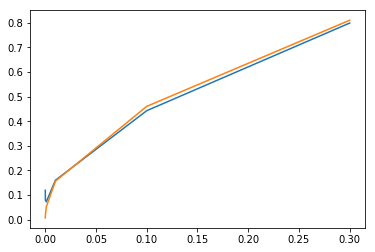

In [23]:
# graph for train and validation loss Vs weight decay
plt.plot(wd,valid_loss)
plt.plot(wd,train_loss)

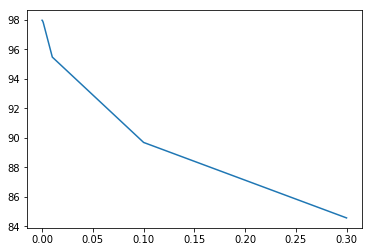

In [24]:
#graph  for validation accuracy Vs weight decay
plt.plot(wd,valid_acc)

In [29]:
p =pd.DataFrame({' wt decay':wd,
             'vld_acc': valid_acc}).sort_values(by='vld_acc')
p['train_loss'] = train_loss
p['valid_loss'] = valid_loss
p.sort_values(by='vld_acc')

,wt decay,vld_acc,train_loss,valid_loss
5,0.3000,84.56,0.006774,0.119176
4,0.1000,89.68,0.017598,0.078918
3,0.0100,95.47,0.052169,0.072291
2,0.0010,97.83,0.156282,0.160092
0,0.0000,97.97,0.460367,0.442726
1,0.0001,97.97,0.810427,0.798943


It can be seen that the model performs better without weight decay compared to weight decay. 

## Question No 4 : Models with Dropout

In [15]:
def get_model_v2(M = 300, p=0):
    modules = []
    modules.append(nn.Linear(28*28, M))
    modules.append(nn.ReLU())
    if p > 0:
        modules.append(nn.Dropout(p))
    modules.append(nn.Linear(M, 10))
    return nn.Sequential(*modules).cuda()

In [17]:
M = 300
lr= 0.001
drp_out = [0, 0.2, 0.4, 0.6, 0.8, 1]
train_loss = []
valid_loss = []
valid_acc  = []
for d in drp_out:
    net = get_model_v2(M,p=d)
    optimizer = optim.Adam(net.parameters(), lr=lr)
    val_acc, val_loss, trn_loss=train_model(train_loader, test_loader, num_epochs=20, model=net, optimizer=optimizer)
    valid_acc.append(val_acc)
    valid_loss.append(val_loss)
    train_loss.append(trn_loss)

Epoch [1/20], Loss: 0.2187
Epoch [1/20], Valid Accuracy: 96.8300, Valid Loss: 0.1085
Epoch [2/20], Loss: 0.0892
Epoch [2/20], Valid Accuracy: 97.3700, Valid Loss: 0.0832
Epoch [3/20], Loss: 0.0607
Epoch [3/20], Valid Accuracy: 97.6100, Valid Loss: 0.0777
Epoch [4/20], Loss: 0.0446
Epoch [4/20], Valid Accuracy: 97.9800, Valid Loss: 0.0676
Epoch [5/20], Loss: 0.0334
Epoch [5/20], Valid Accuracy: 97.7500, Valid Loss: 0.0782
Epoch [6/20], Loss: 0.0295
Epoch [6/20], Valid Accuracy: 97.6600, Valid Loss: 0.0778
Epoch [7/20], Loss: 0.0232
Epoch [7/20], Valid Accuracy: 97.6200, Valid Loss: 0.0782
Epoch [8/20], Loss: 0.0219
Epoch [8/20], Valid Accuracy: 97.8600, Valid Loss: 0.0799
Epoch [9/20], Loss: 0.0173
Epoch [9/20], Valid Accuracy: 97.8100, Valid Loss: 0.0954
Epoch [10/20], Loss: 0.0160
Epoch [10/20], Valid Accuracy: 97.8600, Valid Loss: 0.0913
Epoch [11/20], Loss: 0.0118
Epoch [11/20], Valid Accuracy: 97.8800, Valid Loss: 0.0935
Epoch [12/20], Loss: 0.0142
Epoch [12/20], Valid Accuracy: 97

Epoch [16/20], Valid Accuracy: 97.4700, Valid Loss: 0.1003
Epoch [17/20], Loss: 0.2338
Epoch [17/20], Valid Accuracy: 97.2500, Valid Loss: 0.1000
Epoch [18/20], Loss: 0.2296
Epoch [18/20], Valid Accuracy: 97.2000, Valid Loss: 0.1048
Epoch [19/20], Loss: 0.2285
Epoch [19/20], Valid Accuracy: 97.3700, Valid Loss: 0.0991
Epoch [20/20], Loss: 0.2295
Epoch [20/20], Valid Accuracy: 97.2800, Valid Loss: 0.1017
Epoch [1/20], Loss: 2.3017
Epoch [1/20], Valid Accuracy: 11.1900, Valid Loss: 2.3099
Epoch [2/20], Loss: 2.3013
Epoch [2/20], Valid Accuracy: 11.3400, Valid Loss: 2.3110
Epoch [3/20], Loss: 2.3013
Epoch [3/20], Valid Accuracy: 11.2000, Valid Loss: 2.3104
Epoch [4/20], Loss: 2.3013
Epoch [4/20], Valid Accuracy: 11.1100, Valid Loss: 2.3111
Epoch [5/20], Loss: 2.3013
Epoch [5/20], Valid Accuracy: 10.9300, Valid Loss: 2.3109
Epoch [6/20], Loss: 2.3013
Epoch [6/20], Valid Accuracy: 11.3300, Valid Loss: 2.3107
Epoch [7/20], Loss: 2.3013
Epoch [7/20], Valid Accuracy: 11.2800, Valid Loss: 2.311

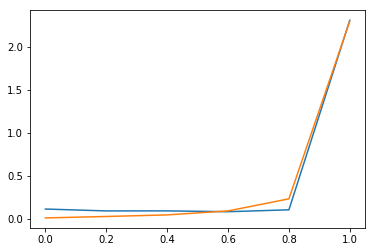

In [20]:
plt.plot(drp_out,valid_loss)
plt.plot(drp_out,train_loss)

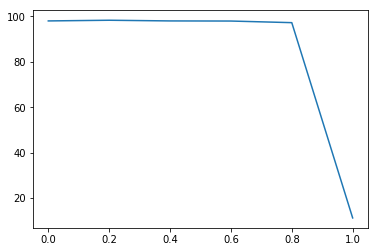

In [21]:
plt.plot(drp_out,valid_acc)

In [22]:
p = pd.DataFrame({' drop out rate':drp_out,
             'vld_acc': valid_acc}).sort_values(by='vld_acc')
p['train_loss'] = train_loss
p['valid_loss'] = valid_loss

,drop out rate,vld_acc
5,1.0,11.29
4,0.8,97.28
3,0.6,97.99
0,0.0,98.04
2,0.4,98.04
1,0.2,98.34


I have considered different dropouts ranging from 0 to1. The highest validation accuracy is achieved with drop out rate of 0.2 in layer 1 and zero drop out rate in layer 2. Compared to weight decay, dropout helps to improve testing accuracy, weight decay didnot improve model performace infact reduced the model performace. But with a dropout rate of 0.2, the validation accuracy increased to 98.34%

## Question 3 : 3 Layer model

In [9]:
def get_model_v2(M, p):  
    modules = []
    modules.append(nn.Linear(28*28, M[0]))
    modules.append(nn.ReLU())
    if p[0] > 0: modules.append(nn.Dropout(p[0]))
    modules.append(nn.Linear(M[0], M[1]))
    modules.append(nn.ReLU())
    if p[1] > 0: modules.append(nn.Dropout(p[1]))
    modules.append(nn.Linear(M[1], 10))
    return nn.Sequential(*modules).cuda()

In this experiment, I tune my 3-layer network in the following order. <br>
1.Architecture finalisation <br>
2.Learning rate tuning <br>
3.dropout <br>
4.weight decay<br>

In [10]:
from sklearn.model_selection import ParameterGrid

The model is run on a grid by all the combination of M1 and M2. Here, the values for the experiment were selected from the paper.

In [14]:
param_grid = {'M1':[300,500],
              'M2':[100,150,500]
             }
p = list(ParameterGrid(param_grid))

In [15]:
lr=0.01
train_loss = []
valid_loss = []
valid_acc  = []
for k in p:
    net = get_model_v2(M=[k['M1'],k['M2']],p=[0,0])
    optimizer = optim.Adam(net.parameters(), lr=lr)
    _,_ ,trn_loss=train_model(train_loader, test_loader, num_epochs=20, model=net, optimizer=optimizer)
    vld_acc,val_loss=model_accuracy_loss(net, test_loader)
    valid_loss.append(val_loss)
    train_loss.append(trn_loss)
    valid_acc.append(vld_acc)
    print('Done')

Epoch [1/20], Loss: 0.2912
Epoch [1/20], Valid Accuracy: 94.2600, Valid Loss: 0.2110
Epoch [2/20], Loss: 0.1901
Epoch [2/20], Valid Accuracy: 94.9000, Valid Loss: 0.1990
Epoch [3/20], Loss: 0.1755
Epoch [3/20], Valid Accuracy: 94.7400, Valid Loss: 0.2046
Epoch [4/20], Loss: 0.1613
Epoch [4/20], Valid Accuracy: 95.3600, Valid Loss: 0.1959
Epoch [5/20], Loss: 0.1441
Epoch [5/20], Valid Accuracy: 95.9200, Valid Loss: 0.1651
Epoch [6/20], Loss: 0.1468
Epoch [6/20], Valid Accuracy: 95.3500, Valid Loss: 0.2024
Epoch [7/20], Loss: 0.1315
Epoch [7/20], Valid Accuracy: 96.4100, Valid Loss: 0.1764
Epoch [8/20], Loss: 0.1365
Epoch [8/20], Valid Accuracy: 96.6000, Valid Loss: 0.1603
Epoch [9/20], Loss: 0.1305
Epoch [9/20], Valid Accuracy: 96.3000, Valid Loss: 0.1926
Epoch [10/20], Loss: 0.1175
Epoch [10/20], Valid Accuracy: 95.9400, Valid Loss: 0.1958
Epoch [11/20], Loss: 0.1197
Epoch [11/20], Valid Accuracy: 96.0700, Valid Loss: 0.1873
Epoch [12/20], Loss: 0.1174
Epoch [12/20], Valid Accuracy: 96

Epoch [16/20], Loss: 0.1096
Epoch [16/20], Valid Accuracy: 95.8300, Valid Loss: 0.2299
Epoch [17/20], Loss: 0.1013
Epoch [17/20], Valid Accuracy: 96.7800, Valid Loss: 0.1889
Epoch [18/20], Loss: 0.1063
Epoch [18/20], Valid Accuracy: 96.0600, Valid Loss: 0.2572
Epoch [19/20], Loss: 0.1085
Epoch [19/20], Valid Accuracy: 96.4300, Valid Loss: 0.2351
Epoch [20/20], Loss: 0.0981
Epoch [20/20], Valid Accuracy: 96.2100, Valid Loss: 0.2636
Done
Epoch [1/20], Loss: 0.3501
Epoch [1/20], Valid Accuracy: 93.6700, Valid Loss: 0.2195
Epoch [2/20], Loss: 0.2351
Epoch [2/20], Valid Accuracy: 93.8300, Valid Loss: 0.2413
Epoch [3/20], Loss: 0.2023
Epoch [3/20], Valid Accuracy: 94.7500, Valid Loss: 0.2006
Epoch [4/20], Loss: 0.1888
Epoch [4/20], Valid Accuracy: 94.8200, Valid Loss: 0.2059
Epoch [5/20], Loss: 0.1723
Epoch [5/20], Valid Accuracy: 94.0100, Valid Loss: 0.2509
Epoch [6/20], Loss: 0.1676
Epoch [6/20], Valid Accuracy: 95.2000, Valid Loss: 0.2278
Epoch [7/20], Loss: 0.1639
Epoch [7/20], Valid Acc

In [16]:
p = pd.DataFrame(p)
p['valid_acc']  = valid_acc
p['train_loss'] = train_loss
p['valid_loss'] = valid_loss

In [17]:
p

,M1,M2,valid_acc,train_loss,valid_loss
0,300,100,96.63,0.105879,0.219713
1,300,150,95.96,0.107845,0.267601
2,300,500,96.12,0.121723,0.204303
3,500,100,96.48,0.102442,0.182949
4,500,150,96.21,0.098060,0.263609
5,500,500,96.00,0.126830,0.199787


From the above experiments, it can be seen that validation accuracy is maximum for M1=300 and M2 =150`

## Tuning Learning rate

In [24]:
valid_acc = []
lr = [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]
for l in lr:
    net = get_model_v2(M=[300,100],p=[0,0])
    optimizer = optim.Adam(net.parameters(), lr=l)
    train_model(train_loader, test_loader, num_epochs=10, model=net, optimizer=optimizer)
    vld_acc,_= model_accuracy_loss(net, test_loader)
    valid_acc.append(vld_acc)

Epoch [1/10], Loss: 1481.8435
Epoch [1/10], Valid Accuracy: 9.9300, Valid Loss: 17.2778
Epoch [2/10], Loss: 27.2117
Epoch [2/10], Valid Accuracy: 10.2700, Valid Loss: 18.8791
Epoch [3/10], Loss: 2.3624
Epoch [3/10], Valid Accuracy: 9.9900, Valid Loss: 18.9502
Epoch [4/10], Loss: 2.3671
Epoch [4/10], Valid Accuracy: 11.5300, Valid Loss: 18.8894
Epoch [5/10], Loss: 2.3630
Epoch [5/10], Valid Accuracy: 10.5000, Valid Loss: 18.8971
Epoch [6/10], Loss: 2.3694
Epoch [6/10], Valid Accuracy: 9.7800, Valid Loss: 18.8947
Epoch [7/10], Loss: 2.3646
Epoch [7/10], Valid Accuracy: 10.5000, Valid Loss: 18.9454
Epoch [8/10], Loss: 2.3697
Epoch [8/10], Valid Accuracy: 9.7500, Valid Loss: 18.8741
Epoch [9/10], Loss: 2.3671
Epoch [9/10], Valid Accuracy: 10.5000, Valid Loss: 18.9361
Epoch [10/10], Loss: 2.3647
Epoch [10/10], Valid Accuracy: 11.5300, Valid Loss: 18.8769
Epoch [1/10], Loss: 3.2400
Epoch [1/10], Valid Accuracy: 28.4900, Valid Loss: 1.8562
Epoch [2/10], Loss: 1.9188
Epoch [2/10], Valid Accura

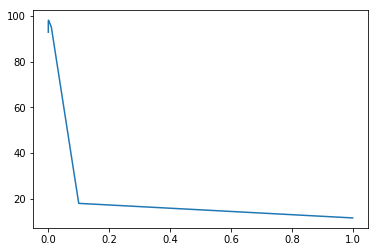

In [25]:
plt.plot(lr,valid_acc)

In [26]:
pd.DataFrame({'lr':lr,
             'vld_acc': valid_acc}).sort_values(by='vld_acc')

,lr,vld_acc
0,1.00000,11.53
1,0.10000,17.90
5,0.00001,92.84
2,0.01000,95.09
4,0.00010,97.78
3,0.00100,98.07


The learning rate with maximum validation accuracy is  0.001

## Dropouts

In [11]:
param_grid = {'p1':[0, 0.2, 0.4, 0.5],
              'p2':[0, 0.2, 0.4, 0.5]
             }
p = list(ParameterGrid(param_grid))

In [12]:
lr=0.001
train_loss = []
valid_loss = []
valid_acc  = []
for k in p:
    net = get_model_v2(M=[300,100],p=[k['p1'],k['p2']])
    optimizer = optim.Adam(net.parameters(), lr=lr)
    _,_ ,trn_loss=train_model(train_loader, test_loader, num_epochs=10, model=net, optimizer=optimizer)
    vld_acc,val_loss=model_accuracy_loss(net, test_loader)
    valid_loss.append(val_loss)
    train_loss.append(trn_loss)
    valid_acc.append(vld_acc)
    print('Done')

Epoch [1/10], Loss: 0.2278
Epoch [1/10], Valid Accuracy: 96.6800, Valid Loss: 0.1078
Epoch [2/10], Loss: 0.0923
Epoch [2/10], Valid Accuracy: 97.2600, Valid Loss: 0.0898
Epoch [3/10], Loss: 0.0654
Epoch [3/10], Valid Accuracy: 97.6800, Valid Loss: 0.0762
Epoch [4/10], Loss: 0.0486
Epoch [4/10], Valid Accuracy: 97.4400, Valid Loss: 0.0847
Epoch [5/10], Loss: 0.0403
Epoch [5/10], Valid Accuracy: 97.5900, Valid Loss: 0.0853
Epoch [6/10], Loss: 0.0331
Epoch [6/10], Valid Accuracy: 97.9800, Valid Loss: 0.0762
Epoch [7/10], Loss: 0.0262
Epoch [7/10], Valid Accuracy: 97.9200, Valid Loss: 0.0800
Epoch [8/10], Loss: 0.0265
Epoch [8/10], Valid Accuracy: 97.5400, Valid Loss: 0.1004
Epoch [9/10], Loss: 0.0227
Epoch [9/10], Valid Accuracy: 97.9400, Valid Loss: 0.0803
Epoch [10/10], Loss: 0.0196
Epoch [10/10], Valid Accuracy: 97.7600, Valid Loss: 0.0902
Done
Epoch [1/10], Loss: 0.2509
Epoch [1/10], Valid Accuracy: 96.5400, Valid Loss: 0.1158
Epoch [2/10], Loss: 0.1047
Epoch [2/10], Valid Accuracy: 9

Epoch [7/10], Loss: 0.0909
Epoch [7/10], Valid Accuracy: 97.8500, Valid Loss: 0.0745
Epoch [8/10], Loss: 0.0862
Epoch [8/10], Valid Accuracy: 97.8300, Valid Loss: 0.0700
Epoch [9/10], Loss: 0.0766
Epoch [9/10], Valid Accuracy: 97.9600, Valid Loss: 0.0705
Epoch [10/10], Loss: 0.0794
Epoch [10/10], Valid Accuracy: 97.8700, Valid Loss: 0.0735
Done
Epoch [1/10], Loss: 0.3582
Epoch [1/10], Valid Accuracy: 96.2400, Valid Loss: 0.1284
Epoch [2/10], Loss: 0.1826
Epoch [2/10], Valid Accuracy: 96.5800, Valid Loss: 0.1078
Epoch [3/10], Loss: 0.1535
Epoch [3/10], Valid Accuracy: 97.4100, Valid Loss: 0.0863
Epoch [4/10], Loss: 0.1312
Epoch [4/10], Valid Accuracy: 97.4700, Valid Loss: 0.0809
Epoch [5/10], Loss: 0.1233
Epoch [5/10], Valid Accuracy: 97.5600, Valid Loss: 0.0815
Epoch [6/10], Loss: 0.1091
Epoch [6/10], Valid Accuracy: 97.5700, Valid Loss: 0.0818
Epoch [7/10], Loss: 0.1068
Epoch [7/10], Valid Accuracy: 97.8000, Valid Loss: 0.0737
Epoch [8/10], Loss: 0.0978
Epoch [8/10], Valid Accuracy: 9

In [13]:
p = pd.DataFrame(p)
p['valid_acc']  = valid_acc
p['train_loss'] = train_loss
p['valid_loss'] = valid_loss

In [17]:
p.sort_values(by='valid_acc')

,p1,p2,valid_acc,train_loss,valid_loss
15,0.5,0.5,97.67,0.124059,0.083597
7,0.2,0.5,97.69,0.065360,0.091864
14,0.5,0.4,97.73,0.115971,0.077759
0,0.0,0.0,97.76,0.019578,0.090246
10,0.4,0.4,97.76,0.087824,0.073149
1,0.0,0.2,97.87,0.025846,0.088577
9,0.4,0.2,97.87,0.079393,0.073486
5,0.2,0.2,97.88,0.045758,0.074760
3,0.0,0.5,97.89,0.036380,0.095956
13,0.5,0.2,97.93,0.096401,0.068521


I have considered different dropouts  in both layers. The highest validation accuracy is achieved with drop out rate of 0.2 in layer 1 and zero drop out rate in layer 2. Compared to weight decay, dropout helps to improve testing accuracy

In [21]:
param_grid = {'p1':[0.2, 0.4, 0.5],
              'p2':[0]
             }
p = list(ParameterGrid(param_grid))

In [22]:
lr=0.001
train_loss = []
valid_loss = []
valid_acc  = []
for k in p:
    net = get_model_v2(M=[300,100],p=[k['p1'],k['p2']])
    optimizer = optim.Adam(net.parameters(), lr=lr)
    _,_ ,trn_loss=train_model(train_loader, test_loader, num_epochs=20, model=net, optimizer=optimizer)
    vld_acc,val_loss=model_accuracy_loss(net, test_loader)
    valid_loss.append(val_loss)
    train_loss.append(trn_loss)
    valid_acc.append(vld_acc)
    print('Done')
p = pd.DataFrame(p)
p['valid_acc']  = valid_acc
p['train_loss'] = train_loss
p['valid_loss'] = valid_loss
p.sort_values(by='valid_acc')

Epoch [1/20], Loss: 0.2473
Epoch [1/20], Valid Accuracy: 96.4100, Valid Loss: 0.1159
Epoch [2/20], Loss: 0.1143
Epoch [2/20], Valid Accuracy: 96.9700, Valid Loss: 0.0983
Epoch [3/20], Loss: 0.0877
Epoch [3/20], Valid Accuracy: 97.6800, Valid Loss: 0.0777
Epoch [4/20], Loss: 0.0722
Epoch [4/20], Valid Accuracy: 97.8700, Valid Loss: 0.0676
Epoch [5/20], Loss: 0.0600
Epoch [5/20], Valid Accuracy: 97.8400, Valid Loss: 0.0762
Epoch [6/20], Loss: 0.0537
Epoch [6/20], Valid Accuracy: 97.8800, Valid Loss: 0.0751
Epoch [7/20], Loss: 0.0484
Epoch [7/20], Valid Accuracy: 98.1000, Valid Loss: 0.0685
Epoch [8/20], Loss: 0.0431
Epoch [8/20], Valid Accuracy: 98.1800, Valid Loss: 0.0676
Epoch [9/20], Loss: 0.0406
Epoch [9/20], Valid Accuracy: 98.0600, Valid Loss: 0.0741
Epoch [10/20], Loss: 0.0375
Epoch [10/20], Valid Accuracy: 98.0200, Valid Loss: 0.0730
Epoch [11/20], Loss: 0.0341
Epoch [11/20], Valid Accuracy: 98.0100, Valid Loss: 0.0724
Epoch [12/20], Loss: 0.0361
Epoch [12/20], Valid Accuracy: 97

,p1,p2,valid_acc,train_loss,valid_loss
1,0.4,0,98.01,0.045517,0.067978
2,0.5,0,98.14,0.062695,0.067033
0,0.2,0,98.34,0.024237,0.081472


## Weight decay

In [15]:
wd = [0, 0.0001, 0.001, 0.01, 0.1, 0.3]
train_loss = []
valid_loss = []
valid_acc  = []
lr=0.001
for w in wd:
    net = get_model_v2(M=[300,150],p=[0.2,0])
    optimizer = optim.Adam(net.parameters(), lr=lr,weight_decay=w)
    _,_ ,trn_loss=train_model(train_loader, test_loader, num_epochs=20, model=net, optimizer=optimizer)
    vld_acc,val_loss=model_accuracy_loss(net, test_loader)
    valid_loss.append(val_loss)
    train_loss.append(trn_loss)
    valid_acc.append(vld_acc)
    print('Done')

Epoch [1/20], Loss: 0.2450
Epoch [1/20], Valid Accuracy: 96.4200, Valid Loss: 0.1164
Epoch [2/20], Loss: 0.1133
Epoch [2/20], Valid Accuracy: 97.0100, Valid Loss: 0.1016
Epoch [3/20], Loss: 0.0864
Epoch [3/20], Valid Accuracy: 97.6900, Valid Loss: 0.0731
Epoch [4/20], Loss: 0.0710
Epoch [4/20], Valid Accuracy: 97.7800, Valid Loss: 0.0724
Epoch [5/20], Loss: 0.0612
Epoch [5/20], Valid Accuracy: 98.0100, Valid Loss: 0.0690
Epoch [6/20], Loss: 0.0520
Epoch [6/20], Valid Accuracy: 97.9700, Valid Loss: 0.0676
Epoch [7/20], Loss: 0.0461
Epoch [7/20], Valid Accuracy: 97.5500, Valid Loss: 0.0910
Epoch [8/20], Loss: 0.0442
Epoch [8/20], Valid Accuracy: 98.0200, Valid Loss: 0.0748
Epoch [9/20], Loss: 0.0394
Epoch [9/20], Valid Accuracy: 97.5100, Valid Loss: 0.0919
Epoch [10/20], Loss: 0.0371
Epoch [10/20], Valid Accuracy: 98.1400, Valid Loss: 0.0720
Epoch [11/20], Loss: 0.0356
Epoch [11/20], Valid Accuracy: 98.1300, Valid Loss: 0.0782
Epoch [12/20], Loss: 0.0336
Epoch [12/20], Valid Accuracy: 97

Epoch [16/20], Loss: 0.5998
Epoch [16/20], Valid Accuracy: 85.5700, Valid Loss: 0.5729
Epoch [17/20], Loss: 0.5991
Epoch [17/20], Valid Accuracy: 85.5400, Valid Loss: 0.5750
Epoch [18/20], Loss: 0.5988
Epoch [18/20], Valid Accuracy: 85.4900, Valid Loss: 0.5723
Epoch [19/20], Loss: 0.5993
Epoch [19/20], Valid Accuracy: 86.9800, Valid Loss: 0.5541
Epoch [20/20], Loss: 0.6006
Epoch [20/20], Valid Accuracy: 84.5300, Valid Loss: 0.5947
Done
Epoch [1/20], Loss: 1.3485
Epoch [1/20], Valid Accuracy: 66.1700, Valid Loss: 1.2753
Epoch [2/20], Loss: 1.2899
Epoch [2/20], Valid Accuracy: 65.1300, Valid Loss: 1.2451
Epoch [3/20], Loss: 1.2861
Epoch [3/20], Valid Accuracy: 64.4100, Valid Loss: 1.2501
Epoch [4/20], Loss: 1.2866
Epoch [4/20], Valid Accuracy: 66.9700, Valid Loss: 1.2594
Epoch [5/20], Loss: 1.2837
Epoch [5/20], Valid Accuracy: 67.1400, Valid Loss: 1.2529
Epoch [6/20], Loss: 1.2795
Epoch [6/20], Valid Accuracy: 63.2900, Valid Loss: 1.2641
Epoch [7/20], Loss: 1.2814
Epoch [7/20], Valid Acc

In [16]:
pd.DataFrame({' wt decay':wd,
             'vld_acc': valid_acc}).sort_values(by='vld_acc')

,wt decay,vld_acc
5,0.3000,67.83
4,0.1000,84.53
3,0.0100,95.94
2,0.0010,97.72
0,0.0000,98.14
1,0.0001,98.19


The 3 layer network too worked well without weight decay. When 3 layer network was compared to 2 layer network, there was no improvement in the validation accuracy compared to the 2 layer network.